
### Main Sections:

1. TensorFlow Basics:
    * Introduction to TensorFlow
    * Installing and Importing TensorFlow
    * Constants and Variables
    * Simple Operations and Tensors
    * Placeholders and Data Feeding
2. Neural Network Fundamentals:
    * Building a Linear Regression Model
    * Loss Functions and Optimization
    * Activation Functions
    * Training Loop and Metrics
3. Hyperparameter Tuning:
    * Importance of Hyperparameters
    * Common Hyperparameters (batch size, epoch, learning rate)
    * GridSearchCV and RandomSearch for Exploration
    * Visualizing Tuning Results
4. Deep Learning Layers:
    * Dense Layers: Parameters and Activation Functions
    * Dropout Layers for Regularization
    * Additional Layer Types (convolutional, recurrent, pooling)
    * Compile Parameters and Training Configuration
5. Additional Notes:
    * Code snippets and resources for further learning
    * Specific questions or challenges you encountered

### Sub-Sections (optional):
    * Within each main section, you can create sub-sections for specific topics or examples.
    * Consider adding headers, bullet points, and diagrams for better organization and clarity.
    * Use different colors or fonts to highlight important information.



### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# special imports for CV and NLP
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("TensorFlow version: ",tf.__version__)
# 2.7.0

2.15.0


In [21]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.15.0


### Load a dataset
Load and prepare the MNIST dataset. The pixel values of the images range from 0 through 255. Scale these values to a range of 0 to 1 by dividing the values by 255.0. This also converts the sample data from integers to floating-point numbers:

In [9]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 1s 0us/step


In [22]:
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [30]:
# Spliting the data into training and test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

AttributeError: ignored

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [ ]:
# Let's also check the overall statistics. Note how each feature covers a very different range:
train_dataset.describe().transpose()

In [ ]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [ ]:
# Normalization
train_dataset.describe().transpose()[['mean', 'std']]

### Helping Variables

In [2]:
NUM_EPOCHS = 2
BATCH_SIZE = 32
SEED = 1

IMG_HEIGHT = 300
IMG_WIDTH = 300
CHANNELS = 3

num_inputs = 1
num_classes = 3

X_train = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0], dtype=float)
y_train = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 5.5], dtype=float)

X_test = np.array([7.0, 11.0], dtype=float)
y_test = np.array([4.0, 6.0], dtype=float)

### Get time series data

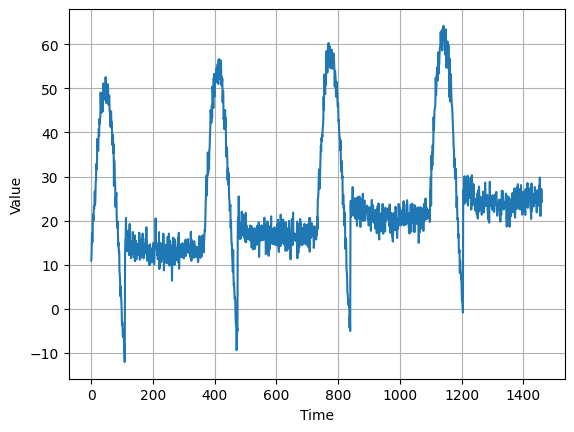

In [4]:
# get some time series data
# the original code is taken from:
# https://github.com/https-deeplearning-ai/tensorflow-1-public

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """ Just an arbitrary pattern """
    return np.where(season_time < 0.3,
                    np.sin(season_time * 4 * np.pi),
                    1 / np.exp(7 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """ Repeats the same pattern at each period """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + \
    seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 3000
time_train = time[:split_time]
series_train = series[:split_time]

WINDOW_SIZE = 20
SHUFFLE_BUFFER_SIZE = 1000

plot_series(time, series)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(series_train,
                           WINDOW_SIZE,
                           BATCH_SIZE,
                           SHUFFLE_BUFFER_SIZE)

### ImageDataGenerator

Official documentation - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [6]:
# extract Horse or Human datasets for computer vision (ImageDataGenerator)
# downloaded from: https://laurencemoroney.com/datasets.html

import os
import zipfile
import shutil

# Get the Horse or Human dataset
path_horse_or_human = "data/horse-or-human.zip"
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = "data/validation-horse-or-human.zip"

local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/horse-or-human')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/validation-horse-or-human')
zip_ref.close()

train_dir = 'data/horse-or-human'
validation_dir = 'data/validation-horse-or-human'

FileNotFoundError: ignored

In [7]:
# augmented ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# default ImageDataGenerator without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # 'categorical'
)

NameError: ignored

Found 1027 images belonging to 2 classes.

Found 256 images belonging to 2 classes.

In [8]:
 # Another option is not to specify the validation set explicitly,
# but to entrust the split to ImageDataGenerator
# In this case, be sure that the seed parameter is the same
# for both sets, otherwise the sets may overlap

train_datagen = ImageDataGenerator(rescale=1./255,
                                   # set validation split ratio
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # 'categorical'
    subset='training',  # set as training data
    seed=SEED)

validation_generator = train_datagen.flow_from_directory(
    train_dir,  # the same directory
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # 'categorical'
    subset='validation',  # set as validation data
    seed=SEED)

NameError: ignored

Found 822 images belonging to 2 classes.

Found 205 images belonging to 2 classes.

### Tokenize and pad sentences


Official documentation for Tokenizer - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/TokenizerOfficial documentation for pad_sequences method - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

### Nerual Netowrk

A neural network model is a collection of layers.

A layer is a defined set of computations which takes a given tensor as input and produces another tensor as output.

For example, a simple layer could just add 1 to all the elements of an input tensor.

The important point is that a layer manipulates (performs a mathematical operation on) an input tensor in some way to produce an output tensor.

Combine a series of layers together and you have a model.

The term “deep learning” comes from the stacking of large numbers of layers on top of eachother (deep in this sense is a synonym for large).

The best way to stack layers together to find patterns in data is constantly changing.

This is why techniques such as *transfer learning* are helpful because they allow you to leverage what has worked for someone else’s similar problem and tailor it to your own.

### Layers
create layers using the `tf.keras.layers` module.

Example include [Dense(fully connected)] and [Conv2D(convolutional)] layes:

In [ ]:
import tensorflow as tf
# Create a dense (or fully connected) layer with TensorFlow
dense_layer = tf.keras.layers.Dense(units,  activation=tf.keras.activations.relu)

# Create a 2D convolutional layer with TensorFlow
conv2d_layer = tf.keras.layers.Conv2D(filters, kernel_size, activation=tf.keras.activations.relu)

And there are many more pre-built layer types available in the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

### Neural Network Models in TensorFlow
The most straightforward way in TensorFlow to a neural network model us using the `tf.keras.Sequential` API, which allows you to stack layers in a way that the computation will be performed sequentially (one layer after the other):

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

**Sequential** is useful for stacking layers where each layer has one input tensor and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the **Flatten**, **Dense**, and **Dropout layers**.

For each example, the model returns a vector of logits or log-odds scores, one for each class.

Flatten Layer:

Purpose: Reshapes input tensors from multidimensional arrays (e.g., images, feature maps) into a single column vector, suitable for fully connected layers.

In [ ]:
model.add(tf.keras.layers.Flatten())

Dense Layer:

- **Key feature**: Fully connected layer where each neuron receives input from all neurons in the previous layer.
- **Parameters**:
  - `units`: Number of neurons in the layer, representing its capacity to learn complex patterns.
  - `activation`: Activation function applied to neuron outputs (e.g., 'relu', 'sigmoid', 'tanh').

In [ ]:
model.add(tf.keras.layers.Dense(64, activation='relu'))

Dropout Layer:

- **Purpose**: Regularization technique to prevent overfitting by randomly setting a fraction of neurons' outputs to zero during training, forcing the model to learn more robust features.
- **Parameter**:
  - `rate`: Probability of a neuron being dropped out (e.g., 0.2 means 20% chance of being dropped).

In [ ]:
model.add(tf.keras.layers.Dropout(0.2))

Common Usage:

- **Flatten** is often used after convolutional or pooling layers to prepare data for fully connected layers.
- **Dense layers** are the primary building blocks for learning complex patterns and making predictions.
- **Dropout** is strategically placed between dense layers to reduce overfitting.

### Activations for Dense Layer

1. **Rectified Linear Unit (ReLU):**
- **Characteristics:** Simple, efficient, fast computations, non-negative outputs.
- **Works best:** Widely applicable, performs well on image recognition, natural language processing, and various regression tasks.
- **Not ideal:** Can suffer from "dying neurons" when activated outputs are consistently zero, potentially harming learning in deeper layers.

2. **Sigmoid:**
- **Characteristics:** S-shaped curve, outputs between 0 and 1, interpretable as probabilities.
- **Works best:** Binary classification tasks where outputs represent probabilities (e.g., spam detection).
- **Not ideal:** Vanishing gradient problem in deeper networks, slow computations, not suitable for multiple outputs.

3. **Tanh:**
- **Characteristics:** Similar to sigmoid but outputs range from -1 to 1.
- **Works best:** Tasks requiring centered outputs (e.g., machine translation, recurrent neural networks).
- **Not ideal:** Similar limitations to sigmoid, less widely used than ReLU.

4. **Leaky ReLU:**
- **Characteristics:** ReLU with a small negative slope for non-zero activations, preventing dying neurons.
- **Works best:** Similar to ReLU but potentially more robust against dying neurons, helpful for deeper networks.
- **Not ideal:** Slightly more complex calculations than ReLU, may not offer significant advantages in simpler architectures.

5. **Softmax:**
- **Characteristics:** Normalizes outputs of a layer to sum to 1, representing probabilities for multiple categories.
- **Works best:** Multi-class classification tasks where outputs represent class probabilities.
- **Not ideal:** Not suitable for regression tasks, computationally expensive for large numbers of classes.

**Bonus:**
- **Exponential Linear Unit (ELU):** Smoothly combines ReLU and leaky ReLU with benefits of both.
- **Swish:** Combines ReLU with a sigmoid-like activation, potentially improving performance on certain tasks.

**Choosing the right activation:**

Consider the following factors:

- **Task type:** Classification, regression, multi-class classification?
- **Network depth:** Deeper networks may benefit from Leaky ReLU or ELU.
- **Computational efficiency:** Simpler activations like ReLU are faster.
- **Interpretability:** Sigmoid and Tanh offer interpretable outputs for probabilities.

## Creating a Model

In [ ]:
# Create a basic neural network model with TensorFlow
model = models.Sequential()

#
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape),
    # Add layers here
		# Computation will happen layer by layer sequentially
])

In [19]:
# If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [20]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[5.7554308e-09, 5.1160578e-09, 2.0690071e-05, 4.5628252e-04,
        7.9367242e-11, 1.3908897e-07, 7.6838769e-13, 9.9951911e-01,
        2.0202133e-07, 3.5682833e-06],
       [2.5495899e-09, 2.1531023e-04, 9.9978179e-01, 1.6704277e-06,
        8.0605596e-13, 4.5231863e-07, 7.0684536e-08, 6.2215138e-12,
        7.4693099e-07, 1.5535925e-15],
       [5.3597870e-07, 9.9823195e-01, 6.6665350e-05, 8.1525495e-06,
        7.3460120e-05, 1.1378068e-05, 6.7557112e-06, 1.3603129e-03,
        2.3847156e-04, 2.3003790e-06],
       [9.9973756e-01, 1.7004214e-09, 2.5158864e-04, 7.0585749e-08,
        2.0832948e-07, 2.7166209e-07, 5.6524264e-06, 3.6237157e-06,
        9.6479837e-08, 1.0104238e-06],
       [6.2924860e-06, 5.6971283e-10, 2.5331681e-06, 3.4923750e-07,
        9.9632359e-01, 8.4422673e-08, 2.1204446e-06, 8.5443207e-05,
        1.4203987e-06, 3.5781688e-03]], dtype=float32)>

In [24]:
# Build the tf.keras model using the Keras model subclassing API:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

## Creating Layers

In [ ]:
from tensorflow.keras import datasets, layers, models
# Creating the Layers

# for Neural Network Model
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(512, activation=tf.nn.relu))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation=tf.nn.softmax))

In [25]:
# Choose an optimizer and loss function for training:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [26]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

 1. Typical Neural Network Architectures using Sequential API

Official documentation - https://www.tensorflow.org/guide/keras/sequential_model

In [ ]:
 # DNN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu',
                          input_shape=(num_inputs, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='relu'),  # regression
])

model.summary()

In [ ]:
 # CNN
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # binary classification
    # multi-class classification
    # layers.Dense(num_classes, activation='softmax')
])

model.summary()

In [ ]:
 # RNN for NLP
model = tf.keras.Sequential([
    layers.Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_length),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(6, activation='softmax')  # multiclass classification
])

model.summary()

In [ ]:
# RNN for time series
model = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=7,
                  strides=1, padding="causal",
                  activation="relu",
                  input_shape=(WINDOW_SIZE, 1)),
    # univariate time series - predict a value based on
    # 'WINDOW_SIZE' previous steps for 1 feature

    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16, return_sequences=True),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # predict one value
])

model.summary()

### Compile Model
Before we start training the model on data we’ve got to compile it model with an optimizer, loss function, and metric.

All three of these are customizable depending on the project you’re working on.

- **Loss function** = measures how wrong the model is (the higher the loss, the more wrong the model, so lower is better). Common loss values include `tf.keras.losses.CategoricalCrossentropy` for multi-class classification problems and `tf.keras.losses.BinaryCrossentropy` for binary classification problems.

- **Optimizer** = tries to adjust the models parameters to lower the loss value. Common optimizers include `tf.keras.optimizers.SGD` (Stochastic Gradient Descent) and `tf.keras.optimizers.Adam`. Each optimizer comes with generally good default settings, however, of the most important values to set is the learning_rate hyperparameter.

- **Metric** = human readable value to interpret how the model is going. Metrics can be defined via `tf.keras.metrics` such as `tf.keras.metrics.Accuracy` or via a list of strings such as `['accuracy']`.

In [ ]:
# Compile model before training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Train Model
You can train your TensorFlow models using the `tf.keras.Model.fit` method and passing it the appropriate hyperparameters.

In [ ]:
# Fit the model to a set of data
model.fit(x=X_train, # data to find patterns in
          y=y_train, # labels for x
          epochs=1, # how many times to go over the whole dataset
          batch_size=32, # number of samples to look at each time
          validation_data=(X_val, # data to validate the learned patterns
                           y_val))

In [12]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.7633044 , -0.4134565 , -1.0231012 ,  0.16598913, -0.26373324,
        -0.2396548 ,  0.323576  , -0.03654948, -0.46044785,  0.36251554]],
      dtype=float32)

The tf.nn.softmax function converts these logits to probabilities for each class:

In [13]:
tf.nn.softmax(predictions).numpy()

array([[0.05397002, 0.07657547, 0.04162213, 0.13669091, 0.08894338,
        0.09111098, 0.16002166, 0.11162931, 0.07306032, 0.16637574]],
      dtype=float32)

In [16]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

#### **Train and evaluate your model**
Use the **Model.fit** method to adjust your model parameters and minimize the loss:

In [17]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2997 - accuracy: 0.9125
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1429 - accuracy: 0.9572
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1079 - accuracy: 0.9673
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0874 - accuracy: 0.9734
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0746 - accuracy: 0.9765


In [27]:
# Use tf.GradientTape to train the model:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [28]:
# test model
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [29]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.14174270629882812, Accuracy: 95.72833251953125, Test Loss: 0.06073475256562233, Test Accuracy: 97.94999694824219
Epoch 2, Loss: 0.04460730776190758, Accuracy: 98.64833068847656, Test Loss: 0.04952728748321533, Test Accuracy: 98.3699951171875
Epoch 3, Loss: 0.02325645461678505, Accuracy: 99.27166748046875, Test Loss: 0.06364025920629501, Test Accuracy: 97.95999908447266
Epoch 4, Loss: 0.012701448984444141, Accuracy: 99.55833435058594, Test Loss: 0.05674344673752785, Test Accuracy: 98.47000122070312
Epoch 5, Loss: 0.010433170944452286, Accuracy: 99.65666198730469, Test Loss: 0.056802958250045776, Test Accuracy: 98.47000122070312


### Evaluate Model
Once you’ve trained a model, you can evaluate its performance on unseen data with `tf.keras.Model.evaluate`:

The Model.evaluate method checks the model's performance, usually on a validation set or test set.

In [18]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0748 - accuracy: 0.9777 - 607ms/epoch - 2ms/step


[0.07480630278587341, 0.9776999950408936]

In [ ]:
# Evaluate a model on unseen data
loss, accuracy = model.evaluate(x=X_test,
                                y=y_test)

Define a loss function for training using losses.SparseCategoricalCrossentropy:

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to -tf.math.log(1/10) ~= 2.3.

In [15]:
loss_fn(y_train[:1], predictions).numpy()

2.3956769

Before you start training, configure and compile the model using Keras Model.compile. Set the optimizer class to adam, set the loss to the loss_fn function you defined earlier, and specify a metric to be evaluated for the model by setting the metrics parameter to accuracy.

In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Save and Load a Whole TensorFlow Model
There are two main ways to save a whole TensorFlow model:

- **`SavedModel` format** — default format for saving a model in TensorFlow, saves a complete TensorFlow program including trained parameters and does not require the original model building code to run. Useful for sharing models across TensorFlow.js, TFLite, TensorFlow Serving and more.

- **`HDF5` format** — a more widely used data standard, however, does not contain as much information as the `SavedModel` format.


You can read the pros and cons of each of these in the TensorFlow documentation on Save and load Keras models.

In [ ]:
# Save model to SavedModel format (default)
model.save('model_save_path')

# Load model back in from SavedModel format
loaded_model = tf.keras.models.load_model('model_save_path')

from https://www.tensorflow.org/tutorials/keras/regression

In [ ]:
history = model.fit()

In [ ]:
# Visualize the model's training progress using the stats stored in the history object:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

In [ ]:
plot_horsepower(x, y)